This is taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and adapted for my needs:

 - uses resnet-50 not resnet-18
 - uses tensorboard for training outputs
 - uses custom data classes as written

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

#my class
import my_vision


def validate_output_dir(path):
    try:
    # Check if the folder exists or not
        if not os.path.isdir(path):
            
            # If not then make the new folder
            os.mkdir(path)

        return True, None
    except Exception as ex:

        return False, ex

cudnn.benchmark = True
plt.ion()   # interactive mode

Load data, specify some transformations - not reszing as I've done that already

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'images/clean_image_data'
image_dataset = my_vision.classification_dataset("training_data.csv",data_dir,data_transforms['train'])

image_datasets = dict()
image_datasets['train'],image_datasets['val'], image_datasets['test'] = torch.utils.data.random_split(image_dataset,[0.7,0.15,0.15])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torch\utils\data\dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualise some images - check we're on the right track

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))



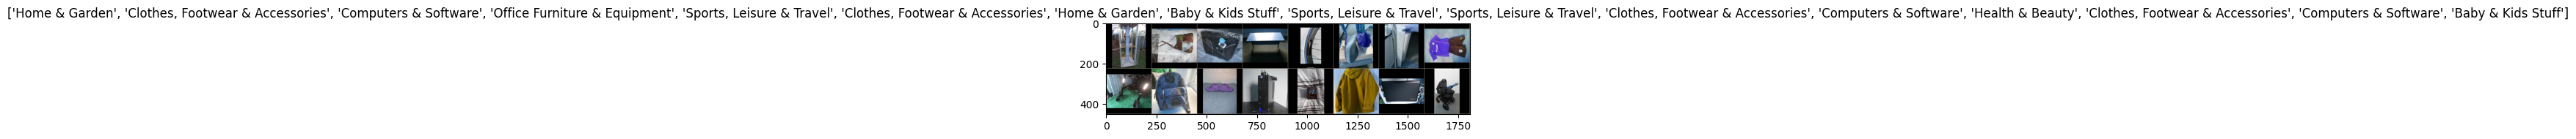

In [4]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[image_dataset.human_category_label(str(x.item()))for x in classes])


Looks OK!

Model training definition - taken direct from tutorial

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,savePath = 'model_evaluation/' ):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    #outputs for tensorboard
                    writer.add_scalar("Loss/train", loss, epoch)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        print(f'Saving weights for Epoch {epoch}')

        torch.save(model,os.path.join(savePath,f'Epoch_{epoch}_weights.pt' ))

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    torch.save(model,os.path.join(savePath,f'best_weights.pt' ))
    writer.close()
    
    return model

Validation code - again from tutorial

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {image_dataset.human_category_label(str(preds[j].item()))}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Set up a pretrained model

In [7]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 13.

model_ft.fc = nn.Linear(num_ftrs,  13)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\martin\miniconda3\envs\Facebook\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Then finetune it:

In [8]:
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [9]:
model_path = os.path.join("model_evaluation","fw_bk")
validate_output_dir(model_path)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25,savePath=model_path)

Epoch 0/1
----------
train Loss: 1.7569 Acc: 0.4202
val Loss: 1.4770 Acc: 0.5140
Saving weights for Epoch 0

Epoch 1/1
----------
train Loss: 1.2675 Acc: 0.5904
val Loss: 1.4634 Acc: 0.5505
Saving weights for Epoch 1

Training complete in 4m 19s
Best val Acc: 0.550502


Phew, done

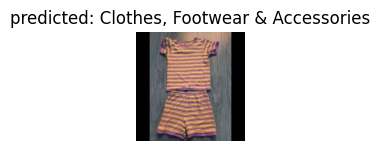

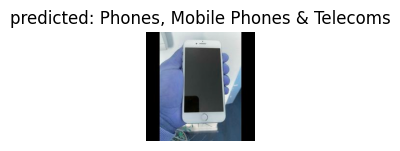

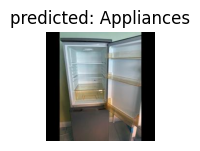

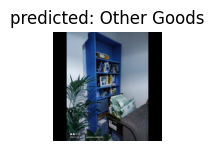

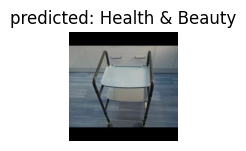

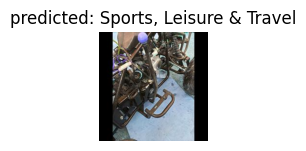

In [10]:
visualize_model(model_ft)

ALternatively: ConvNet as fixed feature extractor

In [11]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 13)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train this alternative model:

In [12]:
model_path = os.path.join("model_evaluation","feature")
validate_output_dir(model_path)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25,savePath=model_path)

Epoch 0/1
----------
train Loss: 1.9883 Acc: 0.3481
val Loss: 1.7502 Acc: 0.4199
Saving weights for Epoch 0

Epoch 1/1
----------
train Loss: 1.7124 Acc: 0.4413
val Loss: 1.6537 Acc: 0.4564
Saving weights for Epoch 1

Training complete in 3m 2s
Best val Acc: 0.456372


Visualise new model

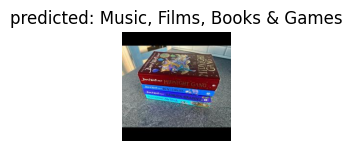

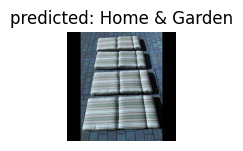

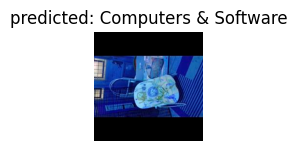

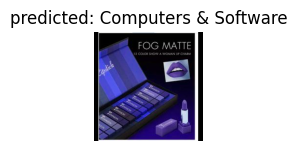

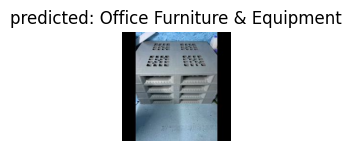

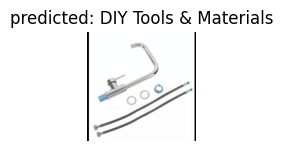

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()